In [9]:
import sys
sys.path.append("..")

import tensorflow as tf
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from surgeNN.models import build_LSTM_per_variable, build_LSTM_stacked
from surgeNN.io import load_predictand,load_predictors
from surgeNN.utils import plot_loss_evolution, get_train_test_val_idx, normalize_timeseries, rmse, sequenced_dataset_from_dataset
from surgeNN.losses import kl_div_softmaxmin, rel_entropy,gevl,diceloss
from scipy import stats
from sklearn.metrics import confusion_matrix
from target_relevance import TargetRelevance #first, in terminal, do->'mamba install kdepy'

Load in & preprocess data

In [11]:
#setttings
tg         = 'den_helder-denhdr-nld-rws.csv' #site to predict
temp_freq  = 6 #hours
n_steps    = 6 #number of timesteps at and before predictand to use predictors at
n_cells    = 5 #n x n grid cells around TG
batch_size = 128

predictand = load_predictand('/Users/timhermans/Documents/Github/surgeNN/input/t_tide_'+str(temp_freq)+'h_anoms_deseasoned_predictands',tg) #open predictand csv
predictors = load_predictors('/Users/timhermans/Documents/Github/surgeNN/input/predictors_'+str(temp_freq)+'hourly',tg,n_cells) #open predictor xarray dataset
predictors = predictors.sel(time=slice('1980','2016')) #period for which we have hydrodynamic output as well
predictor_timesteps = predictors.time.to_dataframe() #store predictor timesteps in separate variable for later

# only use predictands at timesteps for which we have predictor values:
predictand = predictand[(predictand['date']>=predictors.time.isel(time=0).values) & (predictand['date']<=predictors.time.isel(time=-1).values)] 

#select predictors at predictand timesteps
predictors = predictors.sel(time=predictand['date'].values)
predictors = (predictors-predictors.mean(dim='time'))/predictors.std(dim='time',ddof=0) #normalize each variable in dataset
predictand['surge'] = predictand['surge'].rolling(window=5,min_periods=1,center=True).mean()
predictand['surge'] = normalize_timeseries(predictand['surge']) #normalize predictands

surge_obs = predictand['surge'].values #get values from dictionary

my_predictors = np.stack((predictors.msl.values,predictors.w.values,predictors.u10.values,predictors.v10.values),axis=-1)
my_predictors = np.reshape(my_predictors,(len(predictors.time),len(predictors.latitude) * len(predictors.longitude) * 4)) #for LSTM with stacked input

idx_train,idx_test,idx_val = get_train_test_val_idx(surge_obs,[.6,.2,.2],shuffle=False) #split data into training, validation and testing and get indices

#compute loss weights using DenseLoss method
target_relevance = TargetRelevance(surge_obs[np.append(idx_train,idx_val)], alpha=3)
weights = target_relevance.eval(surge_obs[np.append(idx_train,idx_val)]).flatten()

xx_train = sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(my_predictors[idx_train,...]), n_steps, batch_size)
yy_train = sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(surge_obs[idx_train][n_steps-1::]), 1, batch_size)
ww_train = sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(weights[idx_train][n_steps-1::]), 1, batch_size) #test
#zz_train = tf.data.Dataset.zip((xx_train,yy_train,ww_train)) #produce input dataset with DenseLoss weights
zz_train = tf.data.Dataset.zip((xx_train,yy_train)) #produce input dataset without DenseLoss weights

xx_val = sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(my_predictors[idx_val,...]), n_steps, batch_size)
yy_val = sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(surge_obs[idx_val][n_steps-1::]), 1, batch_size)
ww_val = sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(weights[idx_val][n_steps-1::]), 1, batch_size) #test
#zz_val = tf.data.Dataset.zip((xx_val,yy_val,ww_val)) #produce input dataset with DenseLoss weights
zz_val = tf.data.Dataset.zip((xx_val,yy_val)) #produce input dataset with DenseLoss weights

xx_test = sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(my_predictors[idx_test,...]), n_steps, batch_size)
yy_test = sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(surge_obs[idx_test][n_steps-1::]), 1, batch_size)
zz_test = tf.data.Dataset.zip((xx_test,yy_test))


TargetRelevance alpha: 3
Using Silverman Bandwidth 0.1284742466714471


Text(0.5, 1.0, 'DenseLoss loss weights')

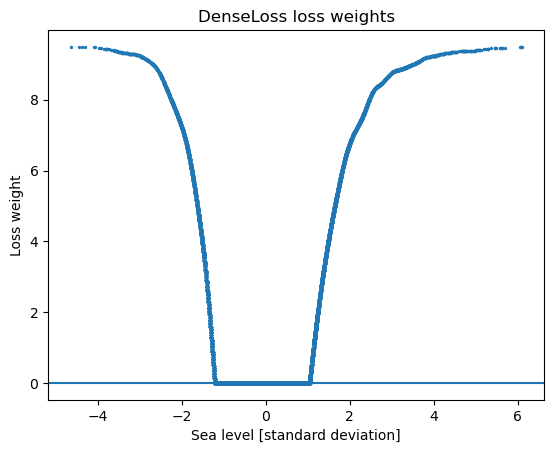

In [12]:
plt.figure()
plt.scatter(surge_obs[np.append(idx_train,idx_val)],weights,s=2)
plt.axhline(y=0)
plt.ylabel('Loss weight')
plt.xlabel('Sea level [standard deviation]')
plt.title('DenseLoss loss weights')

Build & train:

In [4]:
model = build_LSTM_stacked(2, 2, [48,48], [48,48], n_steps,20,20,4, 'model0', .1, 1e-5, rel_entropy,l2=0.02) #set tensorflow build in loss functions (e.g., 'mse') or use something from surgeNN/losses.py

In [5]:
history = model.fit(zz_train,epochs=30,validation_data=zz_val,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                        restore_best_weights=True)]) #loss weights enter the model through zz_train and zz_val, if included in those datasets

Epoch 1/30
247/247 [==============================] - 6s 13ms/step - loss: 0.0046 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 2/30
247/247 [==============================] - 2s 8ms/step - loss: 0.0012 - accuracy: 0.0000e+00 - val_loss: 7.3955e-04 - val_accuracy: 0.0000e+00
Epoch 3/30
247/247 [==============================] - 2s 8ms/step - loss: 5.7341e-04 - accuracy: 0.0000e+00 - val_loss: 4.1326e-04 - val_accuracy: 0.0000e+00
Epoch 4/30
247/247 [==============================] - 2s 8ms/step - loss: 3.3168e-04 - accuracy: 0.0000e+00 - val_loss: 2.5171e-04 - val_accuracy: 0.0000e+00
Epoch 5/30
247/247 [==============================] - 2s 8ms/step - loss: 2.0456e-04 - accuracy: 0.0000e+00 - val_loss: 1.6097e-04 - val_accuracy: 0.0000e+00
Epoch 6/30
247/247 [==============================] - 2s 8ms/step - loss: 1.3220e-04 - accuracy: 0.0000e+00 - val_loss: 1.0717e-04 - val_accuracy: 0.0000e+00
Epoch 7/30
247/247 [==============================] - 2s 8ms/st

In [6]:
surge_cnn_test = model.predict(xx_test,verbose=0).flatten() #make prediction on test set

---CNN---
bulk correlation r=0.025649536786845915
bulk RMSE=0.9187854719461531
Confusion matrix exceedances above 98th percentile:
[[10304     0]
 [  211     0]]
Correlation at timesteps where observations above 98th percentile:
r=-0.0695214355937286
RMSE at timesteps where observations above 98th percentile:
RMSE=3.0298857141441466


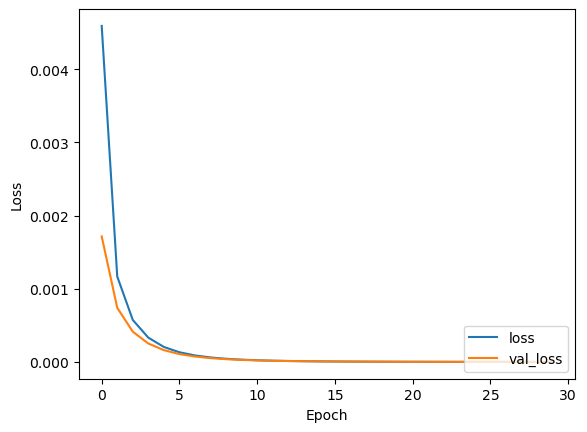

In [7]:
f = plot_loss_evolution(history) #plot training loss

### do some evaluation
threshold_pct = 98 #percentile of storm surge data to look at

surge_obs_test = surge_obs[idx_test][n_steps-1::] #surge_obs[idx_test]
threshold_value = np.percentile(surge_obs[idx_test][n_steps-1::],threshold_pct) #threshold value

surge_obs_test_exceedances = (surge_obs[idx_test][n_steps-1::]>=threshold_value).flatten() #find where storm surges exceed threshold (extremes), for observations
surge_cnn_test_exceedances = (surge_cnn_test>=threshold_value).flatten() #find where storm surges exceed threshold (extremes), for predictions with CNN

print('---CNN---')
print('bulk correlation r='+str(np.corrcoef(surge_cnn_test,surge_obs_test)[0][1]))
print('bulk RMSE='+str(rmse(surge_cnn_test,surge_obs_test)))
print('Confusion matrix exceedances above {0}th percentile:'.format(threshold_pct))
print(confusion_matrix(surge_obs_test_exceedances,surge_cnn_test_exceedances))

print('Correlation at timesteps where observations above {0}th percentile:'.format(threshold_pct))
print('r=' + str(np.corrcoef(surge_cnn_test[surge_obs_test_exceedances],surge_obs_test[surge_obs_test_exceedances])[0][1]))
print('RMSE at timesteps where observations above {0}th percentile:'.format(threshold_pct))
print('RMSE=' + str(rmse(surge_cnn_test[surge_obs_test_exceedances],surge_obs_test[surge_obs_test_exceedances])))


---CNN---
bulk correlation r=0.7930773400666001
bulk RMSE=0.8420173903777424
Confusion matrix exceedances above 98th percentile:
[[20340   271]
 [   92   329]]
Correlation at timesteps where observations above 98th percentile:
r=0.8163631212792326
RMSE at timesteps where observations above 98th percentile:
RMSE=0.5784557177136415

---CoDEC---
bulk correlation r=0.9271770349293676
bulk RMSE=0.3521273103012632
Confusion matrix exceedances above 98th percentile:
[[20508   103]
 [   70   351]]
Correlation at timesteps where observations above 98th percentile:
r=0.9168742281823624
RMSE at timesteps where observations above 98th percentile:
RMSE=0.39142061574991016

alpha=3, kde weighting, rolling mean window of 5, 8 lag, 128 batch size, model = test_model(1, 2, [32], [32,32], n_steps,20,20, 4, 'model0', .1, 1e-5, 'mae',l2=0.01)

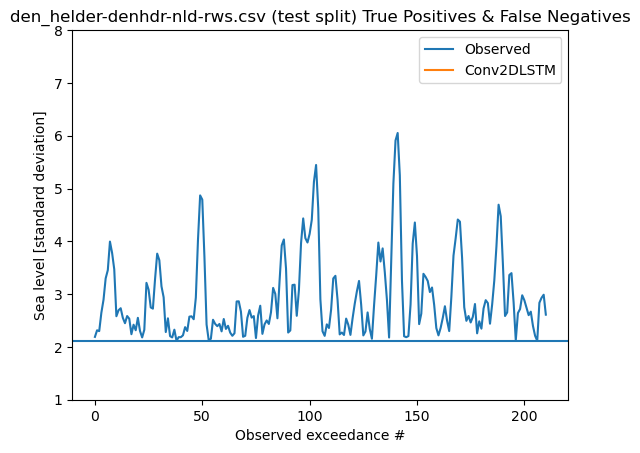

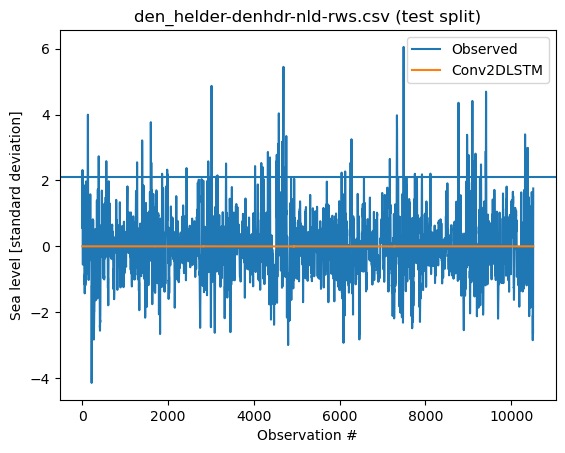

In [8]:
plt.figure()
plt.plot(surge_obs[idx_test][n_steps-1::][surge_obs_test_exceedances],label='Observed')
plt.plot(surge_cnn_test[surge_obs_test_exceedances],label='Conv2DLSTM')
plt.axhline(y=threshold_value)
plt.legend()
plt.ylabel('Sea level [standard deviation]')
plt.xlabel('Observed exceedance #')
plt.title(tg+' (test split) True Positives & False Negatives')
plt.ylim([1,8])
            

plt.figure()
plt.plot(surge_obs[idx_test][n_steps-1::],label='Observed')
plt.plot(surge_cnn_test,label='Conv2DLSTM')
plt.axhline(y=threshold_value)
plt.ylabel('Sea level [standard deviation]')
plt.xlabel('Observation #')
plt.title(tg+' (test split)')
plt.legend()

(-2.0, 8.0)

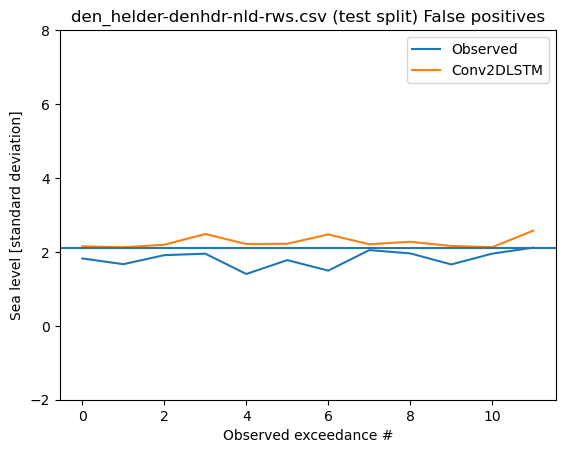

In [12]:
plt.figure()
plt.plot(surge_obs[idx_test][n_steps-1::][surge_cnn_test_exceedances * (surge_obs_test_exceedances==0)],label='Observed')
plt.plot(surge_cnn_test[surge_cnn_test_exceedances * (surge_obs_test_exceedances==0)],label='Conv2DLSTM')
plt.axhline(y=threshold_value)
plt.legend()
plt.ylabel('Sea level [standard deviation]')
plt.xlabel('Observed exceedance #')
plt.title(tg+' (test split) False positives')
plt.ylim([-2,8])

Compare with performance of hydrodynamic model:

In [15]:
surge_codec = xr.open_dataset('/home/jovyan/test_surge_models/CoDEC_ERA5_at_gesla3_tgs_eu_hourly_anoms.nc')
surge_codec = surge_codec.sel(time=predictand['date'].values)
surge_codec['surge'] = surge_codec['surge'].rolling(time=5,min_periods=1,center=True).mean()
surge_codec['surge'] = (surge_codec['surge'] - surge_codec['surge'].mean(dim='time'))/surge_codec['surge'].std(dim='time',ddof=0) #normalize
surge_codec_test = surge_codec.sel(tg=tg).sel(time=predictand['date'].values[idx_test][n_steps-1::]).surge.values #select test timesteps
surge_codec_test_exceedances = (surge_codec_test>=threshold_value).flatten() #find where exceeding threshold
 
print('---CoDEC---')
print('bulk correlation r='+str(np.corrcoef(surge_codec_test,surge_obs_test)[0][1]))
print('bulk RMSE='+str(rmse(surge_codec_test,surge_obs_test)))
print('Confusion matrix exceedances above {0}th percentile:'.format(threshold_pct))
print(confusion_matrix(surge_obs_test_exceedances,surge_codec_test_exceedances))

print('Correlation at timesteps where observations above {0}th percentile:'.format(threshold_pct))
print('r=' + str(np.corrcoef(surge_codec_test[surge_obs_test_exceedances],surge_obs_test[surge_obs_test_exceedances])[0][1]))
print('RMSE at timesteps where observations above {0}th percentile:'.format(threshold_pct))
print('RMSE=' + str(rmse(surge_codec_test[surge_obs_test_exceedances],surge_obs_test[surge_obs_test_exceedances])))


---CoDEC---
bulk correlation r=0.9271770349293676
bulk RMSE=0.3521273103012632
Confusion matrix exceedances above 98th percentile:
[[20508   103]
 [   70   351]]
Correlation at timesteps where observations above 98th percentile:
r=0.9168742281823624
RMSE at timesteps where observations above 98th percentile:
RMSE=0.39142061574991016


(1.0, 8.0)

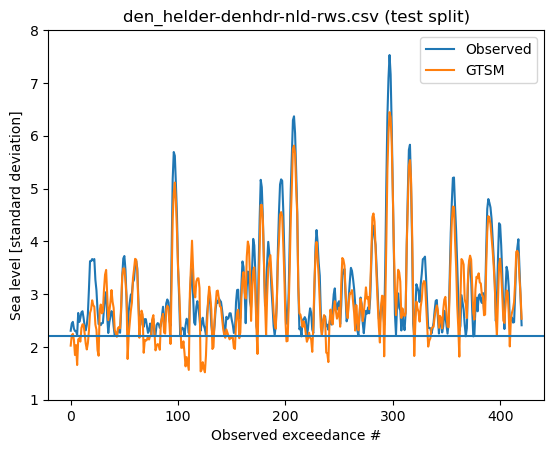

In [16]:
plt.figure()
plt.plot(surge_obs[idx_test][n_steps-1::][surge_obs_test_exceedances],label='Observed')
plt.plot(surge_codec_test[surge_obs_test_exceedances],label='GTSM')
plt.axhline(y=threshold_value)
plt.legend()
plt.ylabel('Sea level [standard deviation]')
plt.xlabel('Observed exceedance #')
plt.title(tg+' (test split)')
plt.ylim([1,8])